In [14]:
from siphon.catalog import TDSCatalog

url = 'http://atlas.niu.edu:8080/thredds/catalog/grib/NARR/catalog.xml'
cat = TDSCatalog(url)
cat_ds = cat.datasets['Full Collection Dataset']

In [15]:
subset_access = cat_ds.subset()
query = subset_access.query()

In [16]:
sorted(v for v in subset_access.variables if v.startswith('Temperature'))

['Temperature_cloud_tops',
 'Temperature_height_above_ground',
 'Temperature_hybrid',
 'Temperature_isobaric',
 'Temperature_parameter_in_canopy_surface',
 'Temperature_pressure_difference_layer',
 'Temperature_surface',
 'Temperature_tropopause']

In [17]:
import datetime as dt
my_date = dt.datetime(1985, 1, 20, 0)

In [18]:
query.variables('Temperature_height_above_ground')
query.time(my_date)
query.accept('netcdf4')

var=Temperature_height_above_ground&time=1985-01-20T00%3A00%3A00&accept=netcdf4

In [19]:
nc = subset_access.get_data(query)

from xarray.backends import NetCDF4DataStore
import xarray as xr
ds = xr.open_dataset(NetCDF4DataStore(nc))

In [21]:
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np

In [22]:
dat = ds.metpy.parse_cf('Temperature_height_above_ground')

In [23]:
data_proj = dat.metpy.cartopy_crs

In [24]:
lat = dat.metpy.y
lon = dat.metpy.x

temperature = ds['Temperature_height_above_ground'][0,0,:]

In [25]:
temperature.metpy.convert_units('degC')

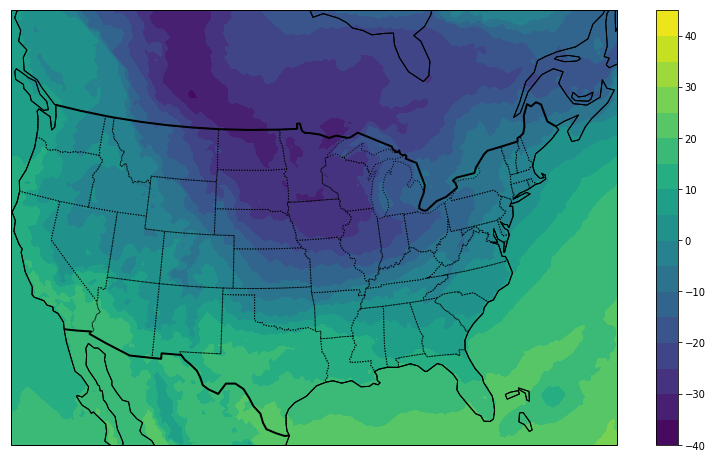

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a plot and basic map projection
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))
ax.coastlines()

levels = np.arange(-40, 50, 5)
cntr = ax.contourf(lon, lat, temperature, transform=data_proj,
                  levels=levels)
fig.colorbar(cntr)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.set_extent((-120, -70, 25, 55), crs=ccrs.PlateCarree())